1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10
from scripts.classifiers import KNearestNeighbor
from scripts.gradient_check import grad_check_sparse
from scripts.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
from scripts.classifiers import Softmax
import time


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [3]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



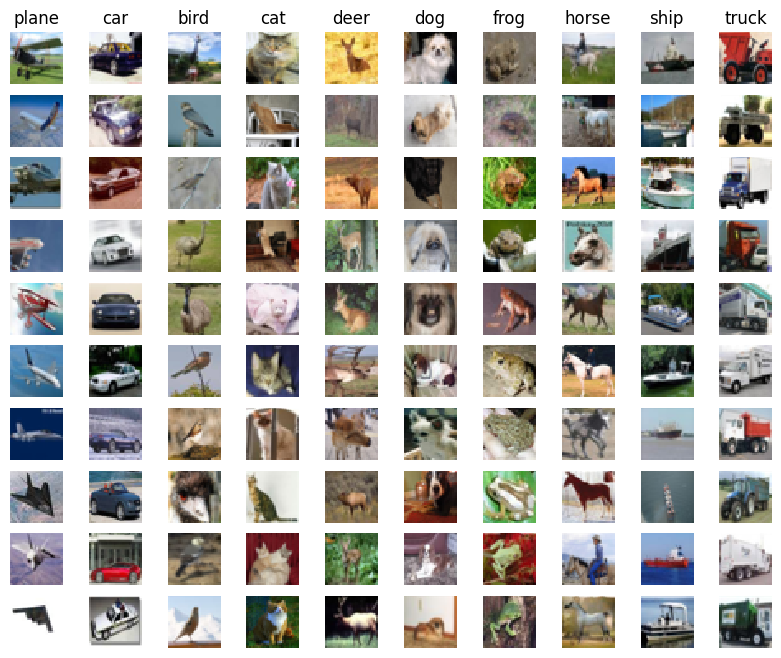

In [4]:
# Заведем названия столбцов для каждого класса изображений
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_len = len(labels)
samples_per_class = 10

# Формиурем рандомный набор изображений
for class_index, class_name in enumerate(labels):
    # Получаем список индексов для рандомных n_samples изображений
    class_indexes = np.random.choice(np.flatnonzero(y_train == class_index), samples_per_class, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * labels_len + class_index + 1
        plt.subplot(samples_per_class, labels_len, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [5]:
# Разделяем данные на выборки
num_train = 5000
mask = list(range(num_train))
knn_X_train = X_train[mask]
knn_y_train = y_train[mask]
# Переводим изображения в одномерные массивы
knn_X_train = np.reshape(knn_X_train, (knn_X_train.shape[0], -1))

num_test = 500
mask = list(range(num_test))
knn_X_test = X_test[mask]
knn_y_test = y_test[mask]
# Переводим изображения в одномерные массивы
knn_X_test = np.reshape(knn_X_test, (knn_X_test.shape[0], -1))


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [6]:
classifier = KNearestNeighbor()
classifier.train(knn_X_train, knn_y_train)

1.5 Выполните классификацию на тестовой выборке

In [7]:
dists = classifier.compute_distances_no_loops(knn_X_test)
dists.shape

(500, 5000)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


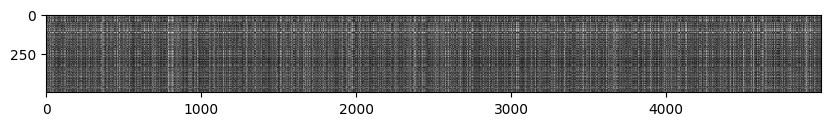

In [8]:
plt.imshow(dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [11]:
accuracy = np.mean(classifier.predict_labels(dists, k=3) == knn_y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.272


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

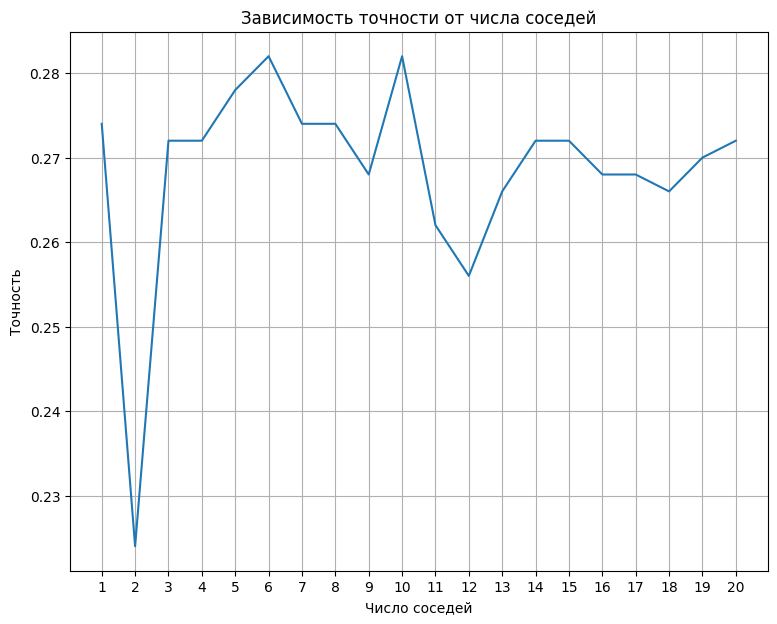

In [14]:
k_choices = range(1, 21)
# рассчитаем долю правильно классифицированных изображений для к от 1 до 20

accuracies = [np.mean(classifier.predict_labels(dists, k=i) == knn_y_test) for i in k_choices]

# Строим график
plt.figure(figsize=(9, 7))
plt.plot(k_choices, accuracies)
plt.title('Зависимость точности от числа соседей')
plt.xlabel('Число соседей')
plt.ylabel('Точность')
plt.xticks(k_choices)
plt.grid(True)
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


k, при котором достигается лучшая точность:  14


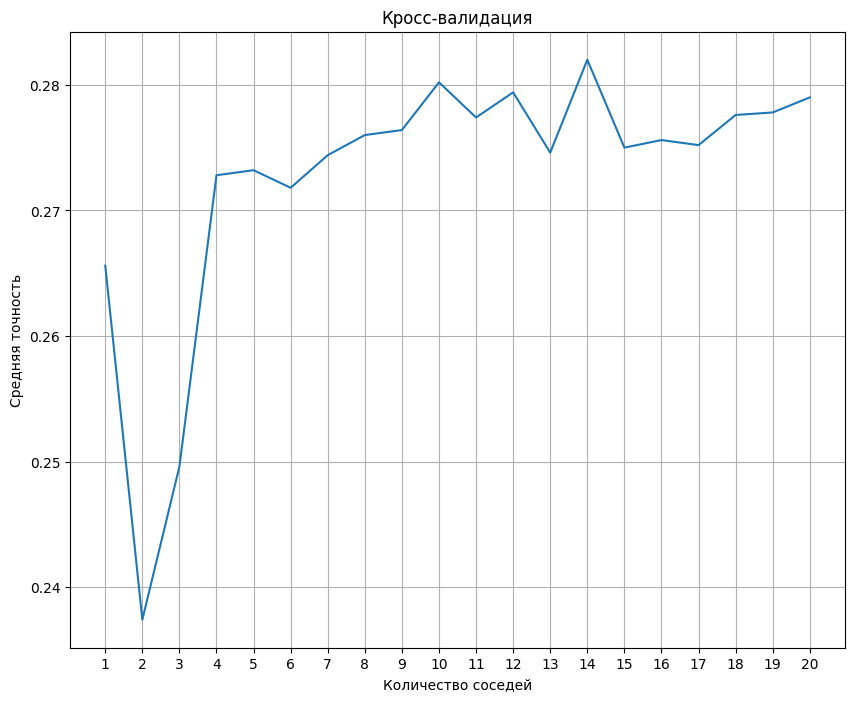

In [22]:
num_folds = 5
k_choices = range(1, 21)

X_train_folds = []
y_train_folds = []

# для вычисления кросс-валидации разделим данные на num_folds частей
X_train_folds = np.array_split(knn_X_train, num_folds)
y_train_folds = np.array_split(knn_y_train, num_folds)

k_to_accuracies = np.zeros((len(k_choices), num_folds))

for k in k_choices:
    for i in range(num_folds):
        # создаем данные и метки для обучения (num_folds-1 штук)
        X_train_temp = np.concatenate(np.compress((np.arange(num_folds) != i), X_train_folds, axis=0))
        y_train_temp = np.concatenate(np.compress((np.arange(num_folds) != i), y_train_folds, axis=0))

        # сохраним обучающие данные
        classifier.train(X_train_temp, y_train_temp)

        # выполним прогнозирование
        y_pred_temp = classifier.predict(X_train_folds[i], k=k)

        # рассчитаем точность
        num_correct = np.sum(y_pred_temp == y_train_folds[i])
        k_to_accuracies[k - 1, i] = num_correct / len(y_pred_temp)

# усредним точность для каждого k
k_to_accuracies = k_to_accuracies.mean(axis=1)

# строим график
plt.plot(k_choices, k_to_accuracies)
plt.title('Кросс-валидация')
plt.xlabel("Количество соседей")
plt.ylabel("Средняя точность")
plt.xticks(k_choices)
plt.grid(True)

best_k = k_choices[np.argmax(k_to_accuracies)]
print("k, при котором достигается лучшая точность: ", best_k)


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [26]:
best_classifier = KNearestNeighbor()
best_classifier.train(knn_X_train, knn_y_train)
print('accuracy: ',np.mean(best_classifier.predict(knn_X_test, k=best_k) == knn_y_test))

accuracy:  0.272


1.11 Сделайте выводы по результатам 1 части задания.

При оптимально подобранном k модель имеет наилучшую точность. При малом k у модели не хватает данных для обучения и получается низкая точность. При большом k происходит переобучение и модель, опять же, теряет в точности. Для максимальной производительности лучше использовать функцию подсчета расстояния, которая основана на векторных операциях

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [27]:
# Разделяем данные на выборки
num_train = 4900
num_test = 9000
num_val = 1000

softmax_X_train = X_train[range(num_train)]
softmax_X_train = np.reshape(softmax_X_train, (softmax_X_train.shape[0], -1)).astype(np.float64)
softmax_y_train = y_train[range(num_train)]

softmax_X_test = X_test[range(num_test)]
softmax_X_test = np.reshape(softmax_X_test, (softmax_X_test.shape[0], -1)).astype(np.float64)
softmax_y_test = y_test[range(num_test)]

softmax_X_val = X_train[range(num_train, num_train + num_val)]
softmax_X_val = np.reshape(softmax_X_val, (softmax_X_val.shape[0], -1)).astype(np.float64)
softmax_y_val = y_train[range(num_train, num_train + num_val)]

softmax_X_dev = X_test[range(num_test, num_test + num_val)]
softmax_X_dev = np.reshape(softmax_X_dev, (softmax_X_dev.shape[0], -1)).astype(np.float64)
softmax_y_dev = y_test[range(num_test, num_test + num_val)]

3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

In [29]:
# Считаем среднее изображение по обучающей выборке softmax_X_train
mean_image = np.mean(softmax_X_train, axis=0)

# Из какждой выборки вычитаем среднее изображение
softmax_X_train -= mean_image
softmax_X_test -= mean_image
softmax_X_val -= mean_image
softmax_X_dev -= mean_image

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

In [30]:
# Используя np.hstack добавляем справа столбец из единиц к каждой выборке
softmax_X_train = np.hstack([softmax_X_train, np.ones((softmax_X_train.shape[0], 1))])
softmax_X_test = np.hstack([softmax_X_test, np.ones((softmax_X_test.shape[0], 1))])
softmax_X_val = np.hstack([softmax_X_val, np.ones((softmax_X_val.shape[0], 1))])
softmax_X_dev = np.hstack([softmax_X_dev, np.ones((softmax_X_dev.shape[0], 1))])

print(softmax_X_train.shape, softmax_X_test.shape, softmax_X_val.shape, softmax_X_dev.shape)

(4900, 3073) (9000, 3073) (1000, 3073) (1000, 3073)


3.4 Реализуйте функции в classifiers/softmax.py




In [34]:
# Генерируем рандомную матрицу весов и используем для подсчета потерь
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.0)

print('loss: %f' % loss)

loss: 8.469801


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [33]:
print("Without reg")
loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.0)

f = lambda w: softmax_loss_naive(w, softmax_X_dev, softmax_y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print()
print("With reg")
loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, softmax_X_dev, softmax_y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Without reg
numerical: 26.854705 analytic: 26.854705, relative error: 1.325314e-11
numerical: -14.354290 analytic: -14.354290, relative error: 8.275782e-12
numerical: -24.942041 analytic: -24.942041, relative error: 3.411551e-12
numerical: 17.682594 analytic: 17.682594, relative error: 1.703797e-11
numerical: -13.742023 analytic: -13.701898, relative error: 1.462069e-03
numerical: -43.251847 analytic: -43.251847, relative error: 9.024740e-13
numerical: 28.888499 analytic: 28.888499, relative error: 7.228162e-12
numerical: 15.644819 analytic: 15.644819, relative error: 3.428545e-11
numerical: -7.141287 analytic: -7.168265, relative error: 1.885334e-03
numerical: 3.566624 analytic: 3.566624, relative error: 3.530738e-12

With reg
numerical: 0.883282 analytic: 0.880134, relative error: 1.785274e-03
numerical: 16.025872 analytic: 16.028328, relative error: 7.662797e-05
numerical: 19.025240 analytic: 19.028242, relative error: 7.888779e-05
numerical: 9.019259 analytic: 9.023906, relative er

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [35]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, softmax_X_dev, softmax_y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 8.469801e+00 computed in 0.172479s
vectorized loss: 8.469801e+00 computed in 0.016558s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [36]:
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(softmax_X_train, softmax_y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 409.803149
iteration 100 / 1500: loss 239.369749
iteration 200 / 1500: loss 145.939024
iteration 300 / 1500: loss 89.750494
iteration 400 / 1500: loss 55.463970
iteration 500 / 1500: loss 35.592824
iteration 600 / 1500: loss 22.865510
iteration 700 / 1500: loss 15.608416
iteration 800 / 1500: loss 11.227776
iteration 900 / 1500: loss 7.930113
iteration 1000 / 1500: loss 6.924236
iteration 1100 / 1500: loss 5.831932
iteration 1200 / 1500: loss 5.095956
iteration 1300 / 1500: loss 5.163808
iteration 1400 / 1500: loss 5.135293
That took 4.906799s


3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [39]:
softmax_y_train_pred = softmax.predict(softmax_X_train)
print('training accuracy: ', np.mean(softmax_y_train_pred == softmax_y_train))
softmax_y_val_pred = softmax.predict(softmax_X_val)
print('validation accuracy: ', np.mean(softmax_y_val_pred == softmax_y_val))

training accuracy:  0.4304081632653061
validation accuracy:  0.359


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [45]:
learning_rates = np.linspace(1e-7, 1e-6, 5)
regularization_strengths = np.linspace(1e3, 1e4, 5)

classifier = Softmax()
params = []
for lr in learning_rates:
    for rs in regularization_strengths:
        params.append((lr, rs))
        
num_folds = 5

X_train_folds = []
y_train_folds = []

# для вычисления кросс-валидации разделим данные на num_folds частей
X_train_folds = np.array_split(softmax_X_train, num_folds)
y_train_folds = np.array_split(softmax_y_train, num_folds)

param_to_accuracies = np.zeros((len(params), num_folds))

for idx, p in enumerate(params):
    for i in range(num_folds):
        # создаем данные и метки для обучения (num_folds-1 штук)
        X_train_temp = np.concatenate(np.compress((np.arange(num_folds) != i), X_train_folds, axis=0))
        y_train_temp = np.concatenate(np.compress((np.arange(num_folds) != i), y_train_folds, axis=0))

        # сохраним обучающие данные
        classifier.train(X_train_temp, y_train_temp, learning_rate=p[0], reg=p[1])

        # выполним прогнозирование
        y_pred_temp = classifier.predict(X_train_folds[i])

        # рассчитаем точность
        num_correct = np.sum(y_pred_temp == y_train_folds[i])
        param_to_accuracies[idx, i] = num_correct / len(y_pred_temp)

# усредним точность для каждой пары
param_to_accuracies = param_to_accuracies.mean(axis=1)

# найдем значения параметров скорости обучения и регуляризации для максимальной точности
best_rate, best_reg = params[np.argmax(param_to_accuracies)]
print(f'rate: {best_rate}, reg: {best_reg}')

rate: 3.2499999999999996e-07, reg: 3250.0


In [46]:
softmax_classifier = Softmax()
softmax_classifier.train(softmax_X_train, softmax_y_train, learning_rate=best_rate, reg=best_reg)

print('accuracy: ', np.mean(softmax_classifier.predict(softmax_X_test) == softmax_y_test))

accuracy:  0.25677777777777777


3.10 Сделайте выводы по третьей части задания

В зависимости от подобранных параметров точность Softmax различается. Векторизованный метод подсчета loss значительно быстрее наивной реализации